In [1]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular, \
                                two_point_angular, \
                                uniform_sphere
from astroML.plotting import hist
from astroML.density_estimation import knuth_bin_width

%matplotlib inline

# Classifying Structure with Correlation Functions

## 2-Point Correlations

Apply the concept of correlation functions to a density function $\rho(\mathbf{x})$ of position $\mathbf{x}$.

#### Example: Angular Correlation Function of a Point Distribution
In this case, positions are given by a spherical coordinate system $\mathbf{n}=(\theta,\phi)$, and $\rho$ is the number density (per unit solid angle $\Omega$).

For an isotropic distribution (unclustered $\rho$, uniform $\bar\rho=\langle\rho(\mathbf{n})\rangle$), variations in $\rho$ at two fixed points are statistically independent over randomly generated distributions.
$$\langle\rho(\mathbf{n}_1)\rho(\mathbf{n}_2)\rangle=\bar\rho^2\quad\text{(unclustered)}$$

Equivalently, there is no covariance (recall from eqn. 3.74)

$$\text{Cov}[\rho(\mathbf{n}_1),\rho(\mathbf{n}_2)]=\langle[\rho(\mathbf{n}_1)-\bar\rho][\rho(\mathbf{n}_2)-\bar\rho]\rangle\equiv\langle\delta\rho(\mathbf{n}_1)\delta\rho(\mathbf{n}_2)\rangle=0\quad\text{(unclustered)}$$

or 2-point correlation function (note the difference from the correlation coefficient in eqn. 3.81)

$$w(\mathbf{n}_1,\mathbf{n}_2)=\left\langle\frac{\delta\rho(\mathbf{n}_1)}{\bar\rho}\frac{\delta\rho(\mathbf{n}_2)}{\bar\rho}\right\rangle=0\quad\text{(unclustered)}.$$


#### A Statistically Significant Detection of a Spatial Correlation Function Implies Clustering of the Data
$$\langle\rho(\mathbf{n}_1)\rho(\mathbf{n}_2)\rangle=\bar\rho^2(1+w(\mathbf{n}_1,\mathbf{n}_2))$$

### How to estimate the ensemble average from a single realization of galaxies?

1. Apply the Cosmological Principle:
        Structure was seeded by randomly generated primordial density fluctuations from quantum fluctuations, 
        statistically uniform and isotropic.

2. Structure formation from seeds is deterministic:
        A deterministic operator determines the observed galaxy distribution from the primordial seeds.
        This same operator transforms the PDF of the seeds to the PDF of the galaxy distribution.
        The galaxy point PDF must therefore be statistically uniform and isotropic.

This justifies a uniform $\bar\rho$, and correlation functions can only depend on $\textbf{distances}$ between points (the only available property not affected by translations/rotations).
$$w(\mathbf{n}_1,\mathbf{n}_2)=w(\psi_{12})$$

#### All pairs of positions with distance $\psi_{12}$ have the same global correlation.
Thus, we can average the density at all pairs of positions the same distance apart over a $\textbf{statistically representative}$ sample.

The result is an estimator of $\textbf{the}$ correlation function of the galaxy point PDF. This is why the galaxy distribution is a powerful probe of cosmology.

Measuring the galaxy correlation function requires estimating the PDF of the measurement:
    - how was the survey footprint chosen (is it a statistically representative volume)?
    - selection function/completeness of survey?
    - angular precision?
    - distance estimation (for 3d correlation, or angular correlation in a fixed spherical shell)?
    - number of observed objects in volume?

#### More general interpretation of the correlation function as a local measurement of clustering.
We can measure a correlation function of any distribution this way--even over volumes of extent smaller than the correlation length of the distribution.

Example in text: Consider a field of view approximately the size of the SDSS Great Wall, centered on the Great Wall.

The interpretation is now different:

1. We lose the interpretation of an ensemble average over a physical PDF that generated the distribution.

2. The estimate of the correlation function represents an excess of clustering at a given distance scale over a random distribution of points.

3. The robustness of this clustering measurement (how non-zero is it?) is recommended to be estimated via bootstrap, by seeing how much the correlation function varies over random galaxy subsamples (by resampling with replacement).

4. A cosmological interpretation of the significance of this clustering must be made in the context of a more globally representative sample.

The information we are measuring is:

1. What is the amplitude of clustering at a particular length scale?

2. How significant is the evidence for clustering?

3. How significant is the evidence for different clustering of different populations in the same field of view?


### Simple Estimator of $w(\psi)$.

Neglect for now the following $\textbf{systematic effects}$:
1. effects of the footprint geometry and interaction of the edges (let's consider full-sky observations), 
2. selection function (assume complete catalog), and 
3. position uncertainties (angular resolution).

The density field is a sum of (2-D angular) Dirac delta functions.
$$\rho(\mathbf{n})=\sum_{i=1}^N\delta(\mathbf{n}-\mathbf{n}_i)$$
has mean density
$$\bar\rho=\int\frac{d\mathbf{n}}{4\pi}\rho(\mathbf{n})=\frac{N}{4\pi}.$$

Consider an angular bin $\Delta\psi$ with $\psi_1\leq\psi\leq\psi_2$.

$$w(\Delta\psi)=\int_{\psi_1}^{\psi_2}\frac{d\psi\sin\psi}{\cos\psi_1-\cos\psi_2}\int_0^{2\pi}\frac{d\phi_\psi}{2\pi}\int\frac{d\mathbf{n}}{4\pi}\left[\frac{\rho(\mathbf{n})-\bar\rho}{\bar\rho}\right]\left[\frac{\rho(\mathbf{n}+\mathbf{\Psi})-\bar\rho}{\bar\rho}\right]$$
$$\equiv\int_{\psi_1}^{\psi_2}\frac{d\psi\sin\psi}{\cos\psi_1-\cos\psi_2}\int_0^{2\pi}\frac{d\phi_\psi}{2\pi}\bar{w}(\mathbf{\Psi})\quad\quad\quad\quad\quad\quad\quad\quad\ $$

We take a "ring average" of
$$\bar w(\mathbf{\Psi})=\int\frac{d\mathbf{n}}{4\pi}\frac{\rho(\mathbf{n})}{\bar\rho}\frac{\rho(\mathbf{n}+\mathbf{\Psi})}{\bar\rho}-1-1+1\quad\quad\quad\quad\quad\quad\ \,$$
$$=\frac{4\pi}{N^2}\sum_{i=1}^N\sum_{j=1}^N\int d\mathbf{n}\ \delta(\mathbf{n}-\mathbf{n}_i)\ \delta(\mathbf{n}-\mathbf{n}_j+\mathbf{\Psi})-1$$
$$=\frac{4\pi}{N^2}\sum_{i=1}^N\sum_{j=1}^N\delta(\mathbf{n}_i-\mathbf{n}_j+\mathbf{\Psi})-1\quad\quad\quad\quad\quad\ \ $$
$$=\frac{4\pi}{N^2}\sum_i\sum_{j\neq i}\delta(\mathbf{n}_i-\mathbf{n}_j+\mathbf{\Psi})+\frac{4\pi}{N}\delta(\mathbf{\Psi})-1.\quad\ \,$$

Let $DD(\Delta\psi)$ be the number of pairs of points with distance in our angular bin.

$$DD\equiv\sum_i\sum_{j\neq i}\int_{\psi_1}^{\psi_2}d\psi\sin\psi\int_0^{2\pi}d\phi_\psi\ \delta(\mathbf{n}_i-\mathbf{n}_j+\mathbf{\Psi})$$

The ring average then gives

$$w(\Delta\psi)=\frac{DD}{RR}+\frac{2\delta_{\psi_1,0}}{1-\cos\psi_2}\frac{1}{N}-1$$

where

$$RR=N^2\frac{\cos\psi_1-\cos\psi_2}{2}=N^2\sin\psi\sin\frac{\Delta\psi}{2}$$

is the corresponding number of observed pairs for a random distribution of points.

The 1-point term with $\delta_{\psi_1,0}$ is only relevant for an angular bin including $\psi=0$, that is a disk.

#### Systematic Effects

Edge effects and selection effects can be taken into account by simulating a random distribution with those effects.

This gives the expected number of $\Delta\psi$-separated pairs $RR$. The angular correlation function is the relative excess number of pairs $DD$ in the data.

$$w(\Delta\psi)=\frac{DD}{RR}-1$$

The astroML implementation does not model position uncertainties, and it assumes a complete catalog (use data with an appropriate magnitude cut) so that selection effects are not present. The field of view is always a rectangle in right ascension and declination coordinates, but other footprint geometries can easily be implemented.

## Landy-Szalay Estimator

Under the $\textbf{ensemble average}$ interpretation of correlation function under a statistically uniform and isotropic PDF, the Landy-Szalay estimator has the same unbiased mean as the standard estimator, but has better interaction with edge effects, and has a lower variance under cosmic variance of the sky ensemble.

$$w(\Delta\psi)=\frac{DD-2DR+RR}{RR}$$

It is worth keeping in mind that when applied to an exact list of point positions, these estimators are not statistical quantities, but are different definitions of a 2-point correlation function. They are exact quantities.

# Sample Code

#### Input data. Apply cuts: redshift slice, RA/DEC rectangular area, magnitude cut.

In [2]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

#### In this example, divide galaxies into red and blue categories separated by $u-r=2.22$.

In [3]:
ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))

data size:
  red gals:  38017
  blue gals: 16883


#### This is where the correlation function is calculated.

In [4]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

@pickle_results: using precomputed results from 'correlation_functions.pkl'


#### Matplotlib

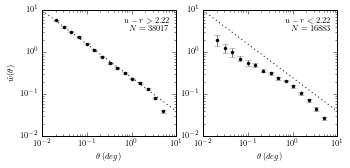

In [5]:
bin_centers = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()

## Under the hood of bootstrap_two_point_angular()

In [ ]:
def bootstrap_two_point_angular(ra, dec, bins, method='standard',
                                Nbootstraps=10, random_state=None):
    """Angular two-point correlation function

    A separate function is needed because angular distances are not
    euclidean, and random sampling needs to take into account the
    spherical volume element.

    Parameters
    ----------
    ra : array_like
        input right ascention, shape = (n_samples,)
    dec : array_like
        input declination
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    Nbootstraps : int
        number of bootstrap resamples
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    dcorr : ndarray
        error estimate on dcorr (sample standard deviation of
        bootstrap resamples)
    bootstraps : ndarray
        The full sample of bootstraps used to compute corr and dcorr
    """
    ra = np.asarray(ra)
    dec = np.asarray(dec)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if (ra.ndim != 1) or (dec.ndim != 1) or (ra.shape != dec.shape):
        raise ValueError('ra and dec must be 1-dimensional '
                         'arrays of the same length')

    n_features = len(ra)
    Nbins = len(bins) - 1
    data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T

    # convert spherical bins to cartesian bins
    bins_transform = angular_dist_to_euclidean_dist(bins)

    bootstraps = []

#### The first bootstrap (i==0) calculates $w$ of the data, the rest calculate $w$ of a random resampling of the data. Note the call to uniform_sphere() to generate a random map with twice the number of data points. This provided routine generates uniform random point distributions for rectangular solid angles.

In [ ]:
    for i in range(Nbootstraps):
        # draw a random sample with N points
        ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                     (min(dec), max(dec)),
                                     2 * len(ra))

        data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T

        if i > 0:
            # random sample of the data
            ind = np.random.randint(0, data.shape[0], data.shape[0])
            data_b = data[ind]
        else:
            data_b = data

        bootstraps.append(two_point(data_b, bins_transform, method=method,
                                    data_R=data_R, random_state=rng))

    bootstraps = np.asarray(bootstraps)
    corr = np.mean(bootstraps, 0)
    corr_err = np.std(bootstraps, 0, ddof=1)

    return corr, corr_err, bootstraps

#### Each $w$ calculation calls two_point().

In [ ]:
def two_point(data, bins, method='standard',
              data_R=None, random_state=None):
    """Two-point correlation function

    Parameters
    ----------
    data : array_like
        input data, shape = [n_samples, n_features]
    bins : array_like
        bins within which to compute the 2-point correlation.
        shape = Nbins + 1
    method : string
        "standard" or "landy-szalay".
    data_R : array_like (optional)
        if specified, use this as the random comparison sample
    random_state : integer, np.random.RandomState, or None
        specify the random state to use for generating background

    Returns
    -------
    corr : ndarray
        the estimate of the correlation function within each bin
        shape = Nbins
    """
    data = np.asarray(data)
    bins = np.asarray(bins)
    rng = check_random_state(random_state)

    if method not in ['standard', 'landy-szalay']:
        raise ValueError("method must be 'standard' or 'landy-szalay'")

    if bins.ndim != 1:
        raise ValueError("bins must be a 1D array")

    if data.ndim == 1:
        data = data[:, np.newaxis]
    elif data.ndim != 2:
        raise ValueError("data should be 1D or 2D")

    n_samples, n_features = data.shape
    Nbins = len(bins) - 1
    
    # shuffle all but one axis to get background distribution
    if data_R is None:
        data_R = data.copy()
        for i in range(n_features - 1):
            rng.shuffle(data_R[:, i])
    else:
        data_R = np.asarray(data_R)
        if (data_R.ndim != 2) or (data_R.shape[-1] != n_features):
            raise ValueError('data_R must have same n_features as data')

    factor = len(data_R) * 1. / len(data)

#### Use Ball Trees implemented by scikit-learn to efficiently count the DD, RR, and DR pairs.

In [ ]:
    if sklearn_has_two_point:
        # Fast two-point correlation functions added in scikit-learn v. 0.14
        KDT_D = KDTree(data)
        KDT_R = KDTree(data_R)

        counts_DD = KDT_D.two_point_correlation(data, bins)
        counts_RR = KDT_R.two_point_correlation(data_R, bins)

    else:
        warnings.warn("Version 0.3 of astroML will require scikit-learn "
                      "version 0.14 or higher for correlation function "
                      "calculations. Upgrade to sklearn 0.14+ now for much "
                      "faster correlation function calculations.")

        BT_D = BallTree(data)
        BT_R = BallTree(data_R)

        counts_DD = np.zeros(Nbins + 1)
        counts_RR = np.zeros(Nbins + 1)

        for i in range(Nbins + 1):
            counts_DD[i] = np.sum(BT_D.query_radius(data, bins[i],
                                                    count_only=True))
            counts_RR[i] = np.sum(BT_R.query_radius(data_R, bins[i],
                                                    count_only=True))

    DD = np.diff(counts_DD)
    RR = np.diff(counts_RR)

    # check for zero in the denominator
    RR_zero = (RR == 0)
    RR[RR_zero] = 1

    if method == 'standard':
        corr = factor ** 2 * DD / RR - 1
    elif method == 'landy-szalay':
        if sklearn_has_two_point:
            counts_DR = KDT_R.two_point_correlation(data, bins)
        else:
            counts_DR = np.zeros(Nbins + 1)
            for i in range(Nbins + 1):
                counts_DR[i] = np.sum(BT_R.query_radius(data, bins[i],
                                                        count_only=True))
        DR = np.diff(counts_DR)

        corr = (factor ** 2 * DD - 2 * factor * DR + RR) / RR

    corr[RR_zero] = np.nan

    return corr

## Compare the previous Landy-Szalay estimator result to the standard estimator.

@pickle_results: using precomputed results from 'correlation_functions2.pkl'


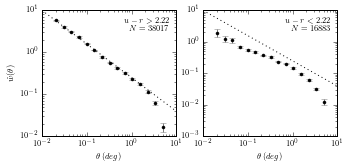

In [6]:
@pickle_results("correlation_functions2.pkl")
def compute_results2(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results2(method='standard')

#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()

# How do we interpret this correlation function and uncertainty?

Interpretation of the correlation is easy: excess clustering at some distance scale, with respect to random point distributions.

#### Concerns about applying bootstrap to estimate the uncertainty of the Great Wall correlation function.
1. When applying bootstrap, the empirical distribution (the data) being resampled needs to be a random sampling of the underlying distribution.
2. But the data volume was not chosen randomly (it is a hand-picked, highly overdense region). Also, the selection of galaxies in the volume is not a random sample of the population in that field of view--it is a (nearly?) complete census up to a given magnitude.
3. The "measurement variance" measured by bootstrap is therefore not associated with any sampling or measurement stochasticity.
4. Is it possible to precisely define an ensemble of Great Walls for which a distribution of correlation functions can be inferred?

Bootstrap is useful to apply to a large galaxy survey that is statistically representative of the Universe, to estimate the uncertainty of measurement of the galaxy correlation function.

Assuming the Great Wall catalog is complete to the given magnitude limit, the uncertainty of the correlation function is probably dominated by the uncertainty of the photometric positions.

#### Using correlation functions to infer clustering vs. uniformity.

Given $N$ galaxies in a field of view of given geometry, observed with known selection bias, the joint probability distribution of correlation functions of random uniform point distributions for any set of distance scales can be determined precisely (either with Monte-Carlo, or semi-analytically as described for example in the Landy and Szalay paper). Thus, the significance of an observation of clustering can be precisely quantified.

#### Using correlation functions to infer separately clustered populations.

Is there any way to quantify how significant is a difference in correlation function between two populations in a non-statistically-representative sample? Not until we identify a self-consistent statistical ensemble for which the chosen field of view is a random example.

For example, the ensemble of all possible samples in the Universe with the same geometric volume dimensions of the Great Wall sample and have the same number of red galaxies and the same number of blue galaxies. Easy to define, but difficult to simulate random samples of such volumes in N-body simulations, though possible with constrained simulations.

## Example: What is the significance of 2-point clustering in the highest angular distance bin for the blue galaxies in the Great Wall using the standard estimator?

mean uniform w:     [-0.00048511]
standard deviation: [ 0.00360777]


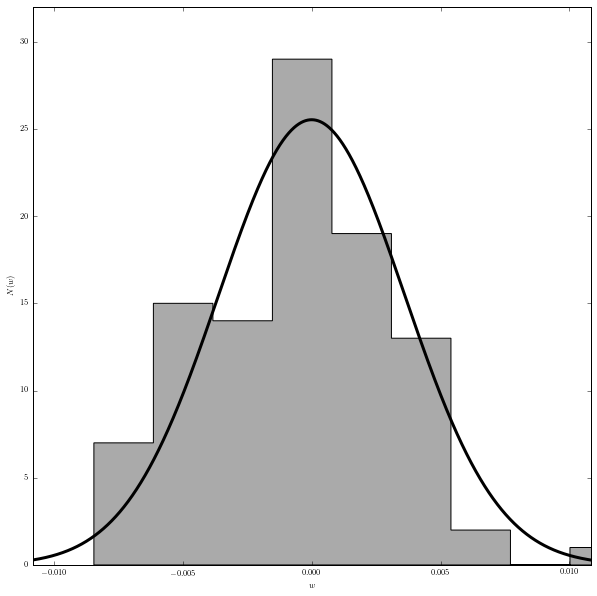

In [7]:
#----------------------------------------------------
# What is the statistical significance of clustering in the highest
# angular distance bin?

highbin = bins[-2:]
npts = len(data_blue)

# Generate nsamples number of uniform distributions and calculate their
# correlation functions.
nsamples = 100
ra, dec = [], []
wrand = []

for i in range(nsamples):
    ra, dec = uniform_sphere((RAmin, RAmax), (DECmin, DECmax), size=npts)
    wrand.append(two_point_angular(ra, dec, highbin, method='standard',
                                   random_state=i))

wrand = np.asarray(wrand)
# The mean and standard deviation of the sample of w for uniform dists.
wrandmean = np.mean(wrand, 0)
wrandsig = np.std(wrand, 0, ddof=1)

print("mean uniform w:    ", wrandmean)
print("standard deviation:", wrandsig)

fig, ax = plt.subplots(figsize=(10, 10))
hist(wrand[:,0], bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
# Get the bin widths to properly normalize the fit PDF.
dx, bins = knuth_bin_width(wrand[:,0], True, disp=False)
x = np.linspace(-3*wrandsig, 3*wrandsig, 10000)
gauss = nsamples * dx * np.exp(-0.5 * (x / wrandsig)**2) / \
    np.sqrt(2 * np.pi) / wrandsig

ax.plot(x, gauss, '-', c='black', lw=3)
ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')

ax.set_xlim(-3*wrandsig, 3*wrandsig)
ax.set_ylim(0, 0.5*nsamples*dx/wrandsig)
plt.show()

If $w_\text{rand}(\Delta\psi)$ is approximately a Gaussian random variable with $\bar w_\text{rand}=0$ and $\sigma_w\simeq0.004$, then the 2-point clustering in $\Delta\psi$ of $w=0.013$ is non-uniform to about $3\sigma$ significance.

In terms of answering the question of how significantly non-zero is a measurement of the correlation function, I would argue this to be a more meaningful error bar than the smaller bootstrap uncertainty of 0.003.

# Comparison of density estimation and clustering algorithms

<table class=MsoTableLightList border=1 cellspacing=0 cellpadding=0
 style='border-collapse:collapse;border:none;mso-border-alt:solid black 1.0pt;
 mso-border-themecolor:text1;mso-yfti-tbllook:1184;mso-padding-alt:0in 5.4pt 0in 5.4pt'>
 <tr style='mso-yfti-irow:-1;mso-yfti-firstrow:yes'>
  <td valign=top style='border-top:double windowtext 1.5pt;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:none;mso-border-top-alt:
  double windowtext 1.5pt;mso-border-bottom-alt:solid windowtext .5pt;
  background:white;mso-background-themecolor:background1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:5'><b><span style='color:black;mso-themecolor:text1'>Method<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border:none;border-top:double windowtext 1.5pt;
  background:white;mso-background-themecolor:background1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:1'><b><span style='color:black;mso-themecolor:text1'>Accuracy<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border:none;border-top:double windowtext 1.5pt;
  background:white;mso-background-themecolor:background1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:1'><b><span style='color:black;mso-themecolor:text1'>Interpretability<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border:none;border-top:double windowtext 1.5pt;
  background:white;mso-background-themecolor:background1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:1'><b><span style='color:black;mso-themecolor:text1'>Simplicity<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border-top:double windowtext 1.5pt;border-left:none;
  border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:text1;
  border-right:none;background:white;mso-background-themecolor:background1;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:1'><b><span style='color:black;mso-themecolor:text1'>Speed<o:p></o:p></span></b></p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:0'>
  <td valign=top style='border:none;mso-border-top-alt:solid windowtext .5pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:68'><b><span style='color:red'>K-nearest-neighbor</span><o:p></o:p></b></p>
  </td>
  <td valign=top style='border:none;border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;mso-border-top-alt:solid black 1.0pt;
  mso-border-top-themecolor:text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:1'>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:4'><b><span style='color:red'>Kernel density estimation<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:2'>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:68'><b><span style='color:red'>Gaussian mixture models<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:3'>
  <td valign=top style='border:none;border-bottom:solid windowtext 1.0pt;
  mso-border-bottom-alt:solid windowtext .5pt;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:4'><b><span style='color:red'>Extreme Deconvolution<o:p></o:p></span></b></p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>M</p>
  </td>
  <td valign=top style='border:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>M</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:4'>
  <td valign=top style='border:none;mso-border-top-alt:solid windowtext .5pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:68'><b><span style='color:#0070C0'>K-means</span><o:p></o:p></b></p>
  </td>
  <td valign=top style='border:none;border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>L</p>
  </td>
  <td valign=top style='border:none;border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
  <td valign=top style='border:none;border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;mso-border-top-alt:solid black 1.0pt;
  mso-border-top-themecolor:text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:5'>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:4'><b><span style='color:#0070C0'>Max-radius
  minimization</span><o:p></o:p></b></p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>L</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>M</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>M</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>M</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:6'>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:68'><b><span style='color:#0070C0'>Mean shift</span><o:p></o:p></b></p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:7'>
  <td valign=top style='border:none;border-bottom:solid windowtext 1.0pt;
  mso-border-bottom-alt:solid windowtext .5pt;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:4'><b><span style='color:#0070C0'>Hierarchical
  clustering</span><o:p></o:p></b></p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>H</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>L</p>
  </td>
  <td valign=top style='border:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>L</p>
  </td>
  <td valign=top style='border:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal'>L</p>
  </td>
 </tr>
 <tr style='mso-yfti-irow:8;mso-yfti-lastrow:yes'>
  <td valign=top style='border:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;mso-border-top-alt:solid windowtext .5pt;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;margin-bottom:.0001pt;line-height:
  normal;mso-yfti-cnfc:68'><b><span style='color:#984807;mso-themecolor:accent6;
  mso-themeshade:128;mso-style-textfill-fill-color:#984807;mso-style-textfill-fill-themecolor:
  accent6;mso-style-textfill-fill-alpha:100.0%;mso-style-textfill-fill-colortransforms:
  lumm=50000'>Correlation functions</span><o:p></o:p></b></p>
  </td>
  <td valign=top style='border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;border-left:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;border-right:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>H</p>
  </td>
  <td valign=top style='border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;border-left:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;border-right:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
  <td valign=top style='border-top:solid black 1.0pt;mso-border-top-themecolor:
  text1;border-left:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;border-right:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
  <td valign=top style='border:none;border-bottom:solid black 1.0pt;mso-border-bottom-themecolor:
  text1;mso-border-top-alt:solid black 1.0pt;mso-border-top-themecolor:text1;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;margin-bottom:.0001pt;
  text-align:center;line-height:normal;mso-yfti-cnfc:64'>M</p>
  </td>
 </tr>
</table>

Evaluate the algorithms using 4 criteria.

H = High

M = Medium

L = Low